# Violence Detection using CNN + LSTM neural network

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/MyDrive/Practice Module/Violence-Detection'

/content/gdrive/MyDrive/Practice Module/Violence-Detection


In [3]:
%matplotlib inline
import cv2
import os
from glob import glob
import random
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation , Dropout


## Helper Functions

We will use the function ```print_progress``` to print the amount of videos processed the datasets

#### Load Data


Setting the parameters

In [5]:
# Frame size  
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (Violence-No Violence)
num_classes = 2

# Number of files to train
_num_files_train = 1

# Number of frames per video
_images_per_file = 100

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".avi"

### Helper-function for getting video frames
Function used to get 100 frames from a video file and convert the frame to a suitable format for the neural net.

In [6]:
def get_frames(file_name):
    
    images = []
    
    vidcap = cv2.VideoCapture(file_name)
    
    success,image = vidcap.read()
        
    count = 0

    while count<_images_per_file:
                
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
    
        images.append(res)
    
        success,image = vidcap.read()
    
        count += 1
        
    resul = np.array(images)
    
    resul = (resul / 255.).astype(np.float16)
        
    return resul

### Helper function to get the names of the data downloaded and label it

In [7]:
in_dir = "../RWF-2000/train"
#in_dir = "../keypoints/train"
#in_dir = "../opt_flow/train"

In [ ]:
def label_video_names(in_dir, sample_size=100):
    
    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []
    
    
    for current_dir, dir_names,file_names in os.walk(in_dir):
        
        for file_name in file_names:
            
            if file_name[0:2] == 'fi':
                labels.append([1,0])
                names.append(file_name)
            elif file_name[0:2] == 'no':
                labels.append([0,1])
                names.append(file_name)
                     
            
    c = list(zip(names,labels))
    # Suffle the data (names and labels)
    res = random.sample(c, sample_size)
    
    names, labels = zip(*res)
            
    return names, labels

## Pre-Trained Model: VGG16

The following creates an instance of the pre-trained VGG16 model using the Keras API. This automatically downloads the required files if you don't have them already.

The VGG16 model contains a convolutional part and a fully-connected (or dense) part which is used for classification. If include_top=True then the whole VGG16 model is downloaded. If include_top=False then only the convolutional part of the VGG16 model is downloaded .

In [8]:
vid_model = VGG16(include_top=True, weights='imagenet')

553476096/553467096 [==============================] - 3s 0us/step


Let's see the model summary

vid_model.summary()


We can observe the shape of the tensors expected as input by the pre-trained VGG16 model. In this case it is images of shape 224 x 224 x 3. Note that we have defined the frame size as 224x224x3. The video frame will be the input of the VGG16 net.

The following chart shows how the data flows when using the VGG16 model for Transfer Learning. First we input and process 100 video frames in batch with the VGG16 model. Just prior to the final classification layer of the VGG16 model, we save the so-called Transfer Values to a cache-file.


In [9]:
# We will use the output of the layer prior to the final
# classification-layer which is named fc2. This is a fully-connected (or dense) layer.
transfer_layer = vid_model.get_layer('fc2')

image_model_transfer = Model(inputs=vid_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the VGG16 net have dimensions:",K.int_shape(vid_model.input)[1:3])

print("The output of the selecter layer of VGG16 net have dimensions: ", transfer_values_size)

The input of the VGG16 net have dimensions: (224, 224)
The output of the selecter layer of VGG16 net have dimensions:  4096


### Generator that process one video through VGG16 each function call

### Functions to save transfer values from VGG16 to later use
We are going to define functions to get the transfer values from VGG16 with defined number of files. Then save the transfer values files used from training in one file and the ones uses for testing in another one. 

#### Split the dataset into training set and test set

In [10]:
def process_image(file_name):
      
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
       
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    try:
        image_batch = get_frames(file_name)
    except Exception as e:
      print('Exception Error :', e, file_name)

    # Note that we use 16 bit floating pt to save memory
    shape = (_images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = image_model_transfer.predict(image_batch)

    return transfer_values


In order to load the saved transfer values into RAM memory we are going to use this two functions:

## Recurrent Neural Network

### Define LSTM architecture

When defining the LSTM architecture we have to take into account the dimensions of the transfer values. From each frame the VGG16 network obtains as output a vector of 4096 transfer values. From each video we are processing 100 frames so we will have 100 x 4096 values per video. The classification must be done taking into account the 100 frames of the video. If any of them detects violence, the video will be classified as violent.


The first input dimension of LSTM neurons is the temporal dimension, in our case it is 100. The second is the size of the features vector (transfer values).


In [17]:
chunk_size = 4096
n_chunks = 100
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [25]:
def build_list(in_dir):
    
    random.seed(3)
    names, labels = [], []
    files = glob(in_dir+'/*.avi')
    for file in files:
        pre = file.split('/')[3].split('.')[0][0:2]
        if pre == 'fi':
            labels.append([1,0])
            names.append(file)
        else:
            labels.append([0,1])
            names.append(file)
            
    c = list(zip(names,labels))
    # Suffle the data (names and labels)
    res = random.sample(c, len(c))
    
    train_set = int(len(names)*0.8)

    
    return res[0:train_set], res[train_set:]
        

In [53]:
def data_generator(file_IDs, batch_size=4):

    num_IDs = len(file_IDs)
              
    for offset in range(0, num_IDs, batch_size):

        batch_IDs = file_IDs[offset:offset+batch_size]

        # Initialise img_stack and seg_stack arrays for this batch
        img_stack = np.array([], dtype=np.float32)
        lbl_stack = np.array([], dtype=np.float32)            

        # For each example
        for ID in batch_IDs:
            file_name = ID[0]
            lbl = np.array(ID[1])
            img = process_image(file_name)
            img = np.expand_dims(img, axis=0)
            img_stack = np.vstack([img_stack, img]) if img_stack.size else img
            lbl_stack = np.vstack([lbl_stack, lbl]) if lbl_stack.size else lbl

    yield img_stack, lbl_stack

## Model training


In [63]:
train_list, val_list = build_list('../RWF-2000/train')

In [ ]:
epoch = 10

train_list, val_list = build_list('../RWF-2000/train')
  
train_datagen = data_generator(train_list, batch_size=16)
val_datagen   = data_generator(val_list,   batch_size=4)
num_train_img = len(train_list)
num_val_img   = len(val_list)
batch_size    = 8

history = model.fit(train_datagen, 
                    steps_per_epoch = (num_train_img//8),
                    validation_data=val_datagen, 
                    validation_steps=(num_val_img//4),
                    verbose=1)

## Test the model

We are going to test the model with 20 % of the total videos. This videos have not been used to train the network. 

In [ ]:
result = model.evaluate(x_test, y_test)

10/10 [==============================] - 1s 28ms/step - loss: 0.5648 - accuracy: 0.7156


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
# Load the pre-trained model
# c3d_model.load_weights("c3d_RWF_2000.h5")

# Evaluate the deep learning model
y_pred = model.predict(np.array(x_test), verbose=0)
print("Confusion matrix")
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print('Accuracy Score :', accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

Confusion matrix
[[141  17]
 [ 74  88]]
Accuracy Score : 0.715625


In [ ]:
y_pred[0:10]

array([[0.6951846 , 0.29789618],
       [0.2769514 , 0.7144979 ],
       [0.6924202 , 0.30114514],
       [0.6955589 , 0.29744658],
       [0.17279832, 0.8256216 ],
       [0.44853747, 0.54276115],
       [0.6954378 , 0.29759148],
       [0.16090003, 0.838785  ],
       [0.6943239 , 0.29892766],
       [0.6932704 , 0.30017135]], dtype=float32)

## Print the model accuracy

In [ ]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.5647885799407959
accuracy 0.715624988079071


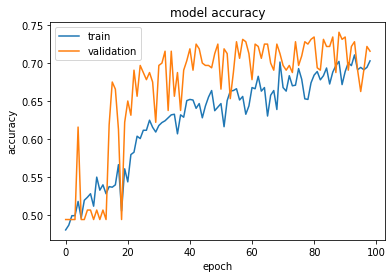

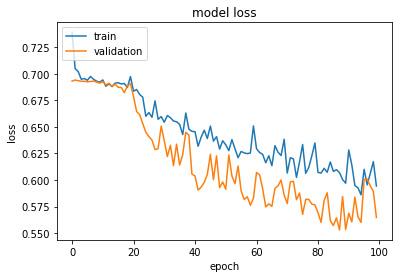

In [ ]:
plt.plot(history.history['accuracy'][1:])
plt.plot(history.history['val_accuracy'][1:])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('rgb_lstm_acc.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('rgb_lstm_loss.png')
plt.show()

In [ ]:
import pandas as pd
df_history = pd.DataFrame(history.history)
df_history.to_csv('results/rgb_lstm_history.csv')

In [ ]:
np.argmax(y_test[0:20], axis=1)

array([1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0])

In [ ]:
np.argmax(y_pred[0:20], axis=1)

array([0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0])